Prerequisites: Connect Colab notebook to "runtimeType: GPU"

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!pip3 install pyedflib

     |████████████████████████████████| 2.4 MB 3.4 MB/s 


In [3]:
%cd '/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN'

/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN


In [4]:
pwd

'/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN'

In [13]:
#Just to see if files got loaded.
file = '/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/data/chbmit/chb02/chb02-summary.txt'
f = open(file, 'r')
file_contents = f.read()
print(file_contents)

Data Sampling Rate: 256 Hz
*************************

Channels in EDF Files:
**********************
Channel 1: FP1-F7
Channel 2: F7-T7
Channel 3: T7-P7
Channel 4: P7-O1
Channel 5: FP1-F3
Channel 6: F3-C3
Channel 7: C3-P3
Channel 8: P3-O1
Channel 9: FP2-F4
Channel 10: F4-C4
Channel 11: C4-P4
Channel 12: P4-O2
Channel 13: FP2-F8
Channel 14: F8-T8
Channel 15: T8-P8
Channel 16: P8-O2
Channel 17: FZ-CZ
Channel 18: CZ-PZ
Channel 19: P7-T7
Channel 20: T7-FT9
Channel 21: FT9-FT10
Channel 22: FT10-T8
Channel 23: T8-P8

File Name: chb02_01.edf
File Start Time: 15:29:39
File End Time: 16:29:39
Number of Seizures in File: 0

File Name: chb02_02.edf
File Start Time: 17:29:49
File End Time: 18:29:49
Number of Seizures in File: 0

File Name: chb02_03.edf
File Start Time: 18:29:56
File End Time: 19:29:56
Number of Seizures in File: 0

File Name: chb02_04.edf
File Start Time: 19:30:03
File End Time: 20:30:03
Number of Seizures in File: 0

File Name: chb02_05.edf
File Start Time: 20:30:10
File End Time:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


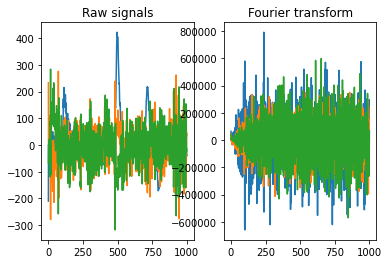

In [6]:
# Plot the signals
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt

# read an edf file
file2 = '/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/data/chbmit/chb02/chb02_16.edf'
signals, signal_headers, header = highlevel.read_edf(file2)

dft = np.fft.fft(signals, axis=1)

plt.subplot(1,2,1)
plt.plot(np.transpose(signals[0:3,:1000]))
plt.title('Raw signals')
plt.subplot(1,2,2)
plt.plot(np.transpose(dft[0:3,:1000]))
plt.title('Fourier transform')
plt.show()

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import pyedflib
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# DATASET: https://physionet.org/files/chbmit/1.0.0/
sampleRate = 256
pathDataSet = '/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/data/chbmit/'# path of the dataset
FirstPartPathOutput='/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/spectograms' #path where the spectogram will be saved
patients = [ "01", "02", "05"]   
_30_MINUTES_OF_DATA = 256*60*30
_MINUTES_OF_DATA_BETWEEN_PRE_AND_SEIZURE = 3
_MINUTES_OF_PREICTAL = 30
_SIZE_WINDOW_IN_SECONDS = 30
_SIZE_WINDOW_SPECTOGRAM = _SIZE_WINDOW_IN_SECONDS*256
nSpectogram=0
signalsBlock=None
SecondPartPathOutput='/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/secondPartOutput'
legendOfOutput=''
isPreictal=''

def loadParametersFromFile(filePath):
    global pathDataSet
    global FirstPartPathOutput
    if(os.path.isfile(filePath)):
        with open(filePath, "r") as f:
                line=f.readline()
                if(line.split(":")[0]=="pathDataSet"):
                    pathDataSet=line.split(":")[1].strip()
                line=f.readline()
                if(line.split(":")[0]=="FirstPartPathOutput"):
                    FirstPartPathOutput=line.split(":")[1].strip()
                
# Band cut filter
def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = butter(order, [low, high], btype='bandstop')
    y = lfilter(i, u, data)
    return y

# Band cut filter, high pass
def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = lfilter(b, a, data)
    return y

#Create pointer to patient file with index equal to index
def loadSummaryPatient(index):
    f = open(pathDataSet+'chb'+patients[index]+'/chb'+patients[index]+'-summary.txt', 'r')
    return f

# Loading patient data (indexPatient). The data is taken from the file with the name indicated in fileOfData
# Returns a numpy vector with the patient data contained in the file
def loadDataOfPatient(indexPatient, fileOfData):
    f = pyedflib.EdfReader(pathDataSet+'chb'+patients[indexPatient]+'/'+fileOfData)  
    n = f.signals_in_file
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sigbufs=cleanData(sigbufs, indexPatient)
    return sigbufs

def cleanData(Data, indexPatient):
    if(patients[indexPatient] in ["19","21"]):
        Data=np.delete(Data, 22, axis=0)
        Data=np.delete(Data, 17, axis=0)
        Data=np.delete(Data, 12, axis=0)
        Data=np.delete(Data, 9, axis=0)
        Data=np.delete(Data, 4, axis=0)
    return Data

# Converting a string indicating a time into an object of type datetime
# and cleaning of dates that do not respect the limits of the hours
def getTime(dateInString):
    time=0
    try:
        time = datetime.strptime(dateInString, '%H:%M:%S')
    except ValueError:
        dateInString=" "+dateInString
        if(' 24' in dateInString):
            dateInString = dateInString.replace(' 24', '23')
            time = datetime.strptime(dateInString, '%H:%M:%S')
            time += timedelta(hours=1)
        else:
            dateInString = dateInString.replace(' 25', '23')
            time = datetime.strptime(dateInString, '%H:%M:%S')
            time += timedelta(hours=2)
    return time

def saveSignalsOnDisk(signalsBlock, nSpectogram):
    global SecondPartPathOutput
    global FirstPartPathOutput
    global legendOfOutput
    global isPreictal

    if not os.path.exists(FirstPartPathOutput):
        os.makedirs(FirstPartPathOutput)
    if not os.path.exists(FirstPartPathOutput+SecondPartPathOutput):
        os.makedirs(FirstPartPathOutput+SecondPartPathOutput) 
    np.save(FirstPartPathOutput+SecondPartPathOutput+'/spec_'+isPreictal+'_'+str(nSpectogram-signalsBlock.shape[0])+'_'+str(nSpectogram-1), signalsBlock)
    legendOfOutput=legendOfOutput+str(nSpectogram-signalsBlock.shape[0])+' '+str(nSpectogram-1) +' '+SecondPartPathOutput+'/spec_'+isPreictal+'_'+str(nSpectogram-signalsBlock.shape[0])+'_'+str(nSpectogram-1) +'.npy\n'


# It divides the data contained in date into windows and creates the spectrograms which are saved on the disk
# S is the factor that indicates how far each window moves
# Returns data not considered, this happens when the data is not divisible by the length of the window
def createSpectrogram(data, S=0):
    global nSpectogram
    global signalsBlock
    global inB
    signals=np.zeros((22,59,114))
    
    t=0
    movement=int(S*256)
    if(S==0):
        movement=_SIZE_WINDOW_SPECTOGRAM        
    while data.shape[1]-(t*movement+_SIZE_WINDOW_SPECTOGRAM) > 0:
        # CREATION OF THE SPETROGRAM FOR ALL CHANNELS
        for i in range(0, 22):
            start = t*movement
            stop = start+_SIZE_WINDOW_SPECTOGRAM
            signals[i,:]=createSpec(data[i,start:stop])
        if(signalsBlock is None):
            signalsBlock=np.array([signals])
        else:
            signalsBlock=np.append(signalsBlock, [signals], axis=0)
        nSpectogram=nSpectogram+1
        if(signalsBlock.shape[0]==50):
            saveSignalsOnDisk(signalsBlock, nSpectogram)
            signalsBlock=None
            # RESCUE OF SIGNALS  
        t = t+1
    return (data.shape[1]-t*_SIZE_WINDOW_SPECTOGRAM)*-1

# Function for the real creation of the spectrogram.
def createSpec(data):
    fs=256
    lowcut=117
    highcut=123

    y=butter_bandstop_filter(data, lowcut, highcut, fs, order=6)
    lowcut=57
    highcut=63
    y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)
    
    cutoff=1
    y=butter_highpass_filter(y, cutoff, fs, order=6)
    
    Pxx=signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=128)[2]    
    Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
    Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
    Pxx = np.delete(Pxx, 0, axis=0)
    
    result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()
    return result

# Spectrogram creation and visualization with the matplotlib library
def createSpecAndPlot(data):
    freqs, bins,Pxx =signal.spectrogram(data, nfft=256, fs=256, return_onesided=True, noverlap=128)
    
    print("Original")
    plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)
    plt.colorbar()
    plt.ylabel('sec')
    plt.xlabel('Hz')
    plt.title('Spettrogramma') 
    plt.show()
    plt.close()
    
    
    fs=256
    lowcut=117
    highcut=123

    y=butter_bandstop_filter(data, lowcut, highcut, fs, order=6)
    lowcut=57
    highcut=63
    y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)
    
    cutoff=1
    y=butter_highpass_filter(y, cutoff, fs, order=6)
    
    #Pxx=signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=128)[2]
    freqs, bins,Pxx =signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=128)
    
    print("Filtered")
    plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)
    plt.colorbar()
    plt.ylabel('sec')
    plt.xlabel('Hz')
    plt.title('Spetrogram')
    plt.show()
    plt.close()
    
    
    Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
    Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
    Pxx = np.delete(Pxx, 0, axis=0)
    
    print("Cleaned but not standard")
    freqs = np.arange(Pxx.shape[0])
    plt.pcolormesh(freqs, bins, 10*np.log10(np.transpose(Pxx)),cmap=plt.cm.jet)
    plt.colorbar()
    plt.ylabel('sec')
    plt.xlabel('Hz')
    plt.title('Spetrogram') 
    plt.show()
    plt.close()
    
    result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()
    
    print("Standard")
    freqs = np.arange(result.shape[1])
    plt.pcolormesh(freqs, bins, result,cmap=plt.cm.jet)
    plt.colorbar()
    plt.ylabel('sec')
    plt.xlabel('Hz')
    plt.title('Spetrogram') 
    plt.show()
    plt.close()
    
    return result

#Class used to represent ranges of data, both Preictal and Interictal
class PreIntData:
    start=0
    end=0
    def __init__(self, s, e):
        self.start=s
        self.end=e
       
#Class used to hold file data, start and end date and time and associated file name
class FileData:
    start=0
    end=0
    nameFile=""
    def __init__(self, s, e, nF):
        self.start=s
        self.end=e
        self.nameFile=nF


#Function that loads all the useful data of the patient analyzed into memory
# Pointer to the summary file of the analyzed patient
#Returns: preictalInterval: vector of PreIntData with all ranges of all preictal data
#                               PreIntData vector with all ranges of all interictal data
#                               FileData vector with all the data of the various files
def createArrayIntervalData(fSummary):
    preictalInteval=[]
    interictalInterval=[]
    interictalInterval.append(PreIntData(datetime.min, datetime.max))
    files=[]
    firstTime=True
    oldTime=datetime.min # equivalent of 0 in dates
    startTime=0
    line=fSummary.readline()
    endS=datetime.min
    while(line):
        data=line.split(':')
        if(data[0]=="File Name"):
            nF=data[1].strip()
            s=getTime((fSummary.readline().split(": "))[1].strip())
            if(firstTime):
                interictalInterval[0].start=s
                firstTime=False
                startTime=s
            while s<oldTime:#if it changes by day I add 24 hours to the date
                s=s+ timedelta(hours=24)
            oldTime=s
            endTimeFile=getTime((fSummary.readline().split(": "))[1].strip())
            while endTimeFile<oldTime:#if it changes by day, add 24 hours to the date
                endTimeFile=endTimeFile+ timedelta(hours=24)
            oldTime=endTimeFile
            files.append(FileData(s, endTimeFile,nF))
            for j in range(0, int((fSummary.readline()).split(':')[1])):
                secSt=int(fSummary.readline().split(': ')[1].split(' ')[0])
                secEn=int(fSummary.readline().split(': ')[1].split(' ')[0])
                ss=s+timedelta(seconds=secSt)- timedelta(minutes=_MINUTES_OF_DATA_BETWEEN_PRE_AND_SEIZURE+_MINUTES_OF_PREICTAL)
                if((len(preictalInteval)==0 or ss > endS) and ss-startTime>timedelta(minutes=20)):
                    ee=ss+ timedelta(minutes=_MINUTES_OF_PREICTAL) 
                    preictalInteval.append(PreIntData(ss,ee))
                endS=s+timedelta(seconds=secEn)
                ss=s+timedelta(seconds=secSt)- timedelta(hours=4) 
                ee=s+timedelta(seconds=secEn)+ timedelta(hours=4) 
                if(interictalInterval[len(interictalInterval)-1].start<ss and interictalInterval[len(interictalInterval)-1].end>ee):
                    interictalInterval[len(interictalInterval)-1].end=ss
                    interictalInterval.append(PreIntData(ee, datetime.max))
                else:
                    if(interictalInterval[len(interictalInterval)-1].start<ee):
                        interictalInterval[len(interictalInterval)-1].start=ee
        line=fSummary.readline()
    fSummary.close()
    interictalInterval[len(interictalInterval)-1].end=endTimeFile
    return preictalInteval, interictalInterval, files
    


def main():
    global SecondPartPathOutput
    global FirstPartPathOutput
    global legendOfOutput
    global nSpectogram
    global signalsBlock
    global isPreictal
    print("START \n")
    loadParametersFromFile("PARAMETERS_DATA_EDITING.txt")
    print("Parameters loaded")
    
    for indexPatient in range(0, len(patients)):
        print("Working on patient "+patients[indexPatient])
        legendOfOutput=""
        allLegend=""
        nSpectogram=0
        
        SecondPartPathOutput='/paz'+patients[indexPatient]
        f = loadSummaryPatient(indexPatient)
        preictalInfo, interictalInfo, filesInfo=createArrayIntervalData(f)
        if(patients[indexPatient]=="19"):
            preictalInfo.pop(0) #Elimination of the data of the first section because it is not considered
        print("Summary patient loaded")
        
        #BEGINNING of interictal data management cycle
        print("START creation interictal spectrogram")
        totInst=0
        #c=0
        #d=0   
        interictalData = np.array([]).reshape(22,0)       
        indexInterictalSegment=0      
        isPreictal=''
        for fInfo in filesInfo:
            fileS=fInfo.start
            fileE=fInfo.end
            intSegStart=interictalInfo[indexInterictalSegment].start
            intSegEnd=interictalInfo[indexInterictalSegment].end
            while(fileS>intSegEnd and indexInterictalSegment<len(interictalInfo)):
                indexInterictalSegment=indexInterictalSegment+1
                intSegStart=interictalInfo[indexInterictalSegment].start
                intSegEnd=interictalInfo[indexInterictalSegment].end
            start=0
            end=0
            if(not fileE<intSegStart or fileS>intSegEnd):
                if(fileS>=intSegStart):
                    start=0
                else:
                    start=(intSegStart-fileS).seconds
                if(fileE<=intSegEnd):
                    end=None
                else:
                    end=(intSegEnd-fileS).seconds
                tmpData=loadDataOfPatient(indexPatient, fInfo.nameFile)
                if(not end==None):
                    end=end*256
                if(tmpData.shape[0]<22):
                    print(patients[indexPatient] +"  HAS A LESSER NUMBER OF CHANNELS")
                else:
                    interictalData=np.concatenate((interictalData, tmpData[0:22,start*256:end]), axis=1)
                    notUsed= createSpectrogram(interictalData)
                    totInst+=interictalData.shape[1]/256-notUsed/256       
                    interictalData = np.delete(interictalData, np.s_[0:interictalData.shape[1]-notUsed], axis=1)
                    
        #window_size: I_data_length = S: (P-30_SEC_PER_OGNI_SEIZURE_data_length)  
        S=(_SIZE_WINDOW_IN_SECONDS*(len(preictalInfo)*_MINUTES_OF_PREICTAL*60-_SIZE_WINDOW_IN_SECONDS*len(preictalInfo)))/totInst 
        if(not (signalsBlock is None)):  
            saveSignalsOnDisk(signalsBlock, nSpectogram)
        signalsBlock=None
            
        print("Spectrogram interictal: "+ str(nSpectogram))
        print("Hours interictal: " +str(totInst/60/60))
        legendOfOutput=str(nSpectogram)+"\n"+legendOfOutput
        legendOfOutput="INTERICTAL"+"\n"+legendOfOutput
        legendOfOutput="SEIZURE: " +str(len(preictalInfo))+"\n"+legendOfOutput
        legendOfOutput=patients[indexPatient]+"\n"+legendOfOutput
        allLegend=legendOfOutput
        legendOfOutput=''
        nSpectogram=0
        print("END creation interictal spectrogram")
        #END of interictal data management cycle
        
        #BEGINNING of preictal data management cycle
        print("START creation preictal spectrogram")
        isPreictal='P'
        contSeizure=-1
        for pInfo in preictalInfo:
            contSeizure=contSeizure+1
            legendOfOutput=legendOfOutput+"SEIZURE "+str(contSeizure)+"\n"
            preictalData = np.array([]).reshape(22,0)
            j=0
            for j in range(0,len(filesInfo)):
                if(pInfo.start>=filesInfo[j].start and pInfo.start<filesInfo[j].end):
                    break
            start=(pInfo.start-filesInfo[j].start).seconds
            if(start<0):
                start=0 # if the preictal starts before the beginning of the file
            end=None
            tmpData=[]
            if(pInfo.end<=filesInfo[j].end):
                end=(pInfo.end-filesInfo[j].start).seconds
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,start*256:end*256]), axis=1)
            else:
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,start*256:]), axis=1)
                end=(pInfo.end-filesInfo[j+1].start).seconds
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j+1].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,0:end*256]), axis=1)
            notUsed= createSpectrogram(preictalData, S=S)
            if(not (signalsBlock is None)): 
                saveSignalsOnDisk(signalsBlock, nSpectogram)
            signalsBlock=None
        
        allLegend=allLegend+"\n"+"PREICTAL"+"\n"+str(nSpectogram)+"\n"+legendOfOutput
        print("Spectrogram preictal: "+ str(nSpectogram))
        print("SEIZURE: " +str(len(preictalInfo)))
        print("END creation preictal spectrogram")
        #END of preictal data management cycle '' '
        
        #REAL preictal data management cycle BEGINNING 
        print("START creation \'real\' preictal spectrogram")
        isPreictal='P_R'
        nSpectogram=0
        contSeizure=-1
        S=0
        legendOfOutput=''
        for pInfo in preictalInfo:
            contSeizure=contSeizure+1
            legendOfOutput=legendOfOutput+"SEIZURE "+str(contSeizure)+"\n"
            preictalData = np.array([]).reshape(22,0)
            j=0
            for j in range(0,len(filesInfo)):
                if(pInfo.start>=filesInfo[j].start and pInfo.start<filesInfo[j].end):
                    break
            start=(pInfo.start-filesInfo[j].start).seconds
            if(start<0):
                start=0 # if the preictal starts before the beginning of the file
            end=None
            tmpData=[]
            if(pInfo.end<=filesInfo[j].end):
                end=(pInfo.end-filesInfo[j].start).seconds
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,start*256:end*256]), axis=1)
            else:
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,start*256:]), axis=1)
                end=(pInfo.end-filesInfo[j+1].start).seconds
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j+1].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,0:end*256]), axis=1)
            notUsed= createSpectrogram(preictalData, S=S)
            if(not (signalsBlock is None)): 
                saveSignalsOnDisk(signalsBlock, nSpectogram)
            signalsBlock=None
        
        allLegend=allLegend+"\n"+"REAL_PREICTAL"+"\n"+str(nSpectogram)+"\n"+legendOfOutput
        print("Spectrogram \'REAL\' preictal: "+ str(nSpectogram))
        print("END creation \'real\' preictal spectrogram")
        #END of preictal data management cycle
        
        text_file = open(FirstPartPathOutput+SecondPartPathOutput+"/legendAllData.txt", "w")
        text_file.write(allLegend)
        text_file.close()
        print("Legend saved on disk")
        print('\n')
    print("END")
            

if __name__ == '__main__':
    main()
    

CNN

In [ ]:

# takes 3 hours for execution with epochs = 100
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv3D, Dropout, Flatten, BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping
from random import shuffle
import math



PathSpectogramFolder = '/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/spectograms'
OutputPath = '/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/spectograms/results.txt'
OutputPathModels ='/content/drive/MyDrive/POJECTS_PURPOSE/EEG_Epilepsy_CNN/spectograms/outputfolder'

interictalSpectograms=[]
preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
patients = [ "01"] 
nSeizure=0

def loadParametersFromFile(filePath):
    global PathSpectogramFolder
    global OutputPath
    global OutputPathModels
    if(os.path.isfile(filePath)):
        with open(filePath, "r") as f:
                line=f.readline()
                if(line.split(":")[0]=="PathSpectogramFolder"):
                    PathSpectogramFolder=line.split(":")[1].strip()
                line=f.readline()
                if(line.split(":")[0]=="OutputPath"):
                    OutputPath=line.split(":")[1].strip()
                line=f.readline()
                if(line.split(":")[0]=="OutputPathModels"):
                    OutputPathModels=line.split(":")[1].strip()

def loadSpectogramData(indexPat):
    global interictalSpectograms
    global preictalSpectograms
    global preictalRealSpectograms
    global nSeizure
    nFileForSeizure=0
    
    interictalSpectograms=[]
    preictalSpectograms=[]
    preictalRealSpectograms=[]
    
    f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
    line=f.readline()
    while(not "SEIZURE" in line):
        line=f.readline()
    nSeizure=int(line.split(":")[1].strip())
    line=f.readline()
    line=f.readline()#reads the number of spectograms. I don't save it since I don't need it
    nSpectograms=int(line.strip())
    nFileForSeizure=math.ceil(math.ceil(nSpectograms/50)/nSeizure)
    line=f.readline()#I read the path of the first file
    
    #Interictal path files reading
    cont=-1
    indFilePathRead=0
    while("npy" in line and indFilePathRead<nSeizure*nFileForSeizure):
        if(indFilePathRead%nFileForSeizure==0):
            interictalSpectograms.append([])
            cont=cont+1
            interictalSpectograms[cont].append(line.split(' ')[2].rstrip())#.rstrip() remove \n
            indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
    line=f.readline()#read PREICTAL
    line=f.readline()#read n° spectogram
    line=f.readline()#read n°seizure(SEIZURE X)

    #Preictal path files reading
    cont=-1
    indFilePathRead=0   
    #while(line and indFilePathRead<nSeizure*nFileForSeizure):    
    while(line.strip()!=""):
        if("SEIZURE" in line):
            line=f.readline()#I have read n ° seizure (SEIZURE X) so I scroll forward
            if(len(line.split(' '))>=3):
                preictalSpectograms.append([])
                cont=cont+1
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
                indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
        
    line=f.readline()#read REAL_PREICTAL
    line=f.readline()#read n° spectogram
    line=f.readline()#read n°seizure(SEIZURE X)

    #Real Preictal path files reading
    cont=-1
    while(line):
        if("SEIZURE" in line):
            line=f.readline()#I have read n ° seizure (SEIZURE X) so I scroll forward
            preictalRealSpectograms.append([])
            cont=cont+1
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
        else:
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
            
        line=f.readline()
    f.close()


def createModel():
    input_shape=(1, 22, 59, 114)
    model = Sequential()
    #C1
    model.add(Conv3D(16, (22, 5, 5), strides=(1, 2, 2), padding='valid',activation='relu',data_format= "channels_first", input_shape=input_shape))
    model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2),data_format= "channels_first",  padding='same'))
    model.add(BatchNormalization())
    
    #C2
    model.add(Conv3D(32, (1, 3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))#incertezza se togliere padding
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2, 2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    #C3
    model.add(Conv3D(64, (1,3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))#incertezza se togliere padding
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2, 2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    
    opt_adam= tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    
    return model

def getFilesPathWithoutSeizure(indexSeizure, indexPat):
    filesPath=[]
    for i in range(0, nSeizure):
        if(i!=indexSeizure):
            filesPath.extend(interictalSpectograms[i])
            filesPath.extend(preictalSpectograms[i])
    shuffle(filesPath)
    return filesPath


def generate_arrays_for_training(indexPat, paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            if('P' in f):
                y = np.repeat([[0,1]],x.shape[0], axis=0)
            else:
                y =np.repeat([[1,0]],x.shape[0], axis=0)
            yield(x,y)
            
def generate_arrays_for_predict(indexPat, paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            yield(x)

class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0, lower=True):
        super(keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.lower=lower


def main():
    print("START")
    if not os.path.exists(OutputPathModels):
        os.makedirs(OutputPathModels)
    loadParametersFromFile("PARAMETERS_CNN.txt")
    #callback=EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)
    callback=EarlyStoppingByLossVal(monitor='val_acc', value=0.975, verbose=1, lower=False)
    print("Parameters loaded")
    
    for indexPat in range(0, len(patients)):
        print('Patient '+patients[indexPat])
        if not os.path.exists(OutputPathModels+"ModelPat"+patients[indexPat]+"/"):
            os.makedirs(OutputPathModels+"ModelPat"+patients[indexPat]+"/")
        loadSpectogramData(indexPat) 
        print('Spectograms data loaded')
        
        result='Patient '+patients[indexPat]+'\n'     
        result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
        for i in range(0, nSeizure):
            print('SEIZURE OUT: '+str(i+1))
            
            print('Training start')  
            model = createModel()
            filesPath=getFilesPathWithoutSeizure(i, indexPat)
            
            model.fit_generator(generate_arrays_for_training(indexPat, filesPath, end=75), #end=75),#It take the first 75%
                                validation_data=generate_arrays_for_training(indexPat, filesPath, start=75),#start=75), #It take the last 25%
                                #steps_per_epoch=10000, epochs=10)
                                steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                                validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                                verbose=2,
                                epochs= 100, max_queue_size=2, shuffle=True, callbacks=[callback])# 100 epochs is better 
            print('Training end') 
            
            print('Testing start')
            filesPath=interictalSpectograms[i]
            interPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
            filesPath=preictalRealSpectograms[i]
            preictPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
            print('Testing end')
            

            # Creates a HDF5 file 
            model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
            print("Model saved")
            
            #to plot the model
            #plot_model(model, to_file="CNNModel", show_shapes=True, show_layer_names=True)
            
            if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
                os.makedirs(OutputPathModels+"OutputTest"+"/")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
            
            secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
            acc=0#accumulator
            fp=0
            tp=0
            fn=0
            lastTenResult=list()
            
            for el in interPrediction:
                if(el[1]>0.5):
                    acc=acc+1
                    lastTenResult.append(1)
                else:
                    lastTenResult.append(0)
                if(len(lastTenResult)>10):
                    acc=acc-lastTenResult.pop(0)
                if(acc>=8):
                  fp=fp+1
                  lastTenResult=list()
                  acc=0
            
            lastTenResult=list()
            for el in preictPrediction:
                if(el[1]>0.5):
                    acc=acc+1
                    lastTenResult.append(1)
                else:
                    lastTenResult.append(0)
                if(len(lastTenResult)>10):
                    acc=acc-lastTenResult.pop(0)
                if(acc>=8):
                  tp=tp+1 
                else:
                    if(len(lastTenResult)==10):
                       fn=fn+1 
                       
            sensitivity=tp/(tp+fn)
            FPR=fp/(secondsInterictalInTest/(60*60))
            
            result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
            result=result+str(sensitivity)+','+str(FPR)+'\n'
            print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
            print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
        with open(OutputPath, "a+") as myfile:
            myfile.write(result)
    

if __name__ == '__main__':
    main()
    